# Example 2 - Training on one data set - evaluating on another

We use some AST data to train the model, and then we predict into the future based on the trained PINN parameters.

In [1]:
import sys
import os

# Get the root project folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Add the src folder to sys.path
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import yaml
from elec_pinn.data.preprocessing   import Preprocessor     
from elec_pinn.data.loader          import ScalerLoader     
from elec_pinn.cli                  import load_config, get_model
from elec_pinn.utils.visualization  import plot_pinn_performance 

In [3]:
cfg = load_config("example2_config.yaml")

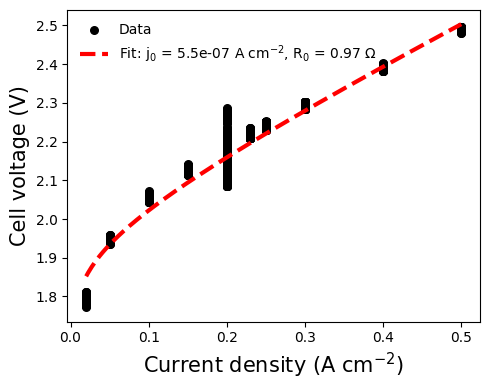

In [4]:
dp = Preprocessor(cfg["data"]["dataset_name"])
df = dp.preprocess(
                    t0 = cfg["data"]["t0"],
                    t1 = cfg["data"]["t1"],
                    plot_fit = True,   # show the performance fit curve
                    plot_raw = False   # show raw data over time
                )

Intiantiate a 'scaler' based on feature and targetnames as well as the scaling range. Then, use the .get_loader() method to convert the input data into Pytorch DataLoaders that are useful when working with neural networks. Here, the dataset is split into train, validation, test, and lastly a combined dataloader, where the combined DataLoader contains the whole dataset.

The training DataLoader is shuffled in time while the validation, testing and all (combined) dataloaders are not shuffled in time. The shuffling was found to enhance prediction accuracy by trial-and-error.

The resulting dataloaders are also normalized to the range specified in the config file.

In [5]:
scaler = ScalerLoader(
                feature_cols=cfg["data"]["feature_names"],
                target_cols=cfg["data"]["target_names"],
                scale_range=tuple(cfg["data"]["scale_range"]) 
                     ).fit(df)

train_loader, val_loader, test_loader, all_loader = scaler.get_loaders(
    df,
    f_train=cfg["data"]["train_frac"],
    f_val=  cfg["data"]["val_frac"],
    f_test=1 - cfg["data"]["train_frac"] - cfg["data"]["val_frac"],
    batch_sizes=tuple(cfg["training"]["batch_sizes"])
)

We then pull the requested PINN version. In this example we use the FullPINN containing all the prediction functionalities. Next, the model is trained using the training and validation loaders.

In [6]:
model   = get_model(cfg)
training_results = model.train_model( train_loader, 
                                      val_loader,
                                      cfg['training']['epochs'],
                                      cfg['training']['save_freq'],
                                      cfg['training']['patience'])

Epoch 1 | Train: 562.375590, Val: 404.595978:   0%|▏                                                                                                                    | 1/500 [00:02<17:24,  2.09s/it]

Epoch 1: New best model saved! Loss: 404.5959777832


Epoch 2 | Train: 341.907043, Val: 219.680638:   0%|▍                                                                                                                    | 2/500 [00:04<17:49,  2.15s/it]

Epoch 2: New best model saved! Loss: 219.6806384671


Epoch 3 | Train: 193.652123, Val: 105.076373:   1%|▋                                                                                                                    | 3/500 [00:06<17:52,  2.16s/it]

Epoch 3: New best model saved! Loss: 105.0763731926


Epoch 4 | Train: 100.896333, Val: 41.851919:   1%|▉                                                                                                                     | 4/500 [00:08<18:27,  2.23s/it]

Epoch 4: New best model saved! Loss: 41.8519191127


Epoch 5 | Train: 47.887906, Val: 12.558069:   1%|█▏                                                                                                                     | 5/500 [00:11<18:41,  2.27s/it]

Epoch 5: New best model saved! Loss: 12.5580688907


Epoch 6 | Train: 20.757203, Val: 2.586520:   1%|█▍                                                                                                                      | 6/500 [00:13<17:59,  2.19s/it]

Epoch 6: New best model saved! Loss: 2.5865204527


Epoch 7 | Train: 8.518034, Val: 1.476966:   1%|█▋                                                                                                                       | 7/500 [00:15<17:53,  2.18s/it]

Epoch 7: New best model saved! Loss: 1.4769662575


Epoch 59 | Train: 0.336200, Val: 1.407573:  12%|██████████████                                                                                                         | 59/500 [02:07<15:54,  2.16s/it]

Epoch 59: New best model saved! Loss: 1.4075732255


Epoch 60 | Train: 0.322332, Val: 1.333587:  12%|██████████████▎                                                                                                        | 60/500 [02:09<15:49,  2.16s/it]

Epoch 60: New best model saved! Loss: 1.3335871696


Epoch 61 | Train: 0.308870, Val: 1.257799:  12%|██████████████▌                                                                                                        | 61/500 [02:11<15:33,  2.13s/it]

Epoch 61: New best model saved! Loss: 1.2577989198


Epoch 62 | Train: 0.295821, Val: 1.190144:  12%|██████████████▊                                                                                                        | 62/500 [02:14<15:33,  2.13s/it]

Epoch 62: New best model saved! Loss: 1.1901436857


Epoch 63 | Train: 0.283074, Val: 1.125282:  13%|██████████████▉                                                                                                        | 63/500 [02:16<15:36,  2.14s/it]

Epoch 63: New best model saved! Loss: 1.1252816666


Epoch 64 | Train: 0.270727, Val: 1.069305:  13%|███████████████▏                                                                                                       | 64/500 [02:18<15:37,  2.15s/it]

Epoch 64: New best model saved! Loss: 1.0693046354


Epoch 65 | Train: 0.258739, Val: 1.013162:  13%|███████████████▍                                                                                                       | 65/500 [02:20<15:31,  2.14s/it]

Epoch 65: New best model saved! Loss: 1.0131623375


Epoch 66 | Train: 0.247253, Val: 0.956462:  13%|███████████████▋                                                                                                       | 66/500 [02:22<15:20,  2.12s/it]

Epoch 66: New best model saved! Loss: 0.9564618348


Epoch 67 | Train: 0.235949, Val: 0.906860:  13%|███████████████▉                                                                                                       | 67/500 [02:24<15:42,  2.18s/it]

Epoch 67: New best model saved! Loss: 0.9068604467


Epoch 68 | Train: 0.225188, Val: 0.854746:  14%|████████████████▏                                                                                                      | 68/500 [02:27<15:33,  2.16s/it]

Epoch 68: New best model saved! Loss: 0.8547459026


Epoch 69 | Train: 0.214715, Val: 0.815672:  14%|████████████████▍                                                                                                      | 69/500 [02:29<15:34,  2.17s/it]

Epoch 69: New best model saved! Loss: 0.8156720943


Epoch 70 | Train: 0.204656, Val: 0.770201:  14%|████████████████▋                                                                                                      | 70/500 [02:31<15:27,  2.16s/it]

Epoch 70: New best model saved! Loss: 0.7702006462


Epoch 71 | Train: 0.194934, Val: 0.724382:  14%|████████████████▉                                                                                                      | 71/500 [02:33<15:34,  2.18s/it]

Epoch 71: New best model saved! Loss: 0.7243824022


Epoch 72 | Train: 0.185643, Val: 0.682190:  14%|█████████████████▏                                                                                                     | 72/500 [02:35<15:41,  2.20s/it]

Epoch 72: New best model saved! Loss: 0.6821898760


Epoch 73 | Train: 0.176705, Val: 0.646810:  15%|█████████████████▎                                                                                                     | 73/500 [02:38<15:42,  2.21s/it]

Epoch 73: New best model saved! Loss: 0.6468098933


Epoch 74 | Train: 0.168207, Val: 0.617553:  15%|█████████████████▌                                                                                                     | 74/500 [02:40<15:34,  2.19s/it]

Epoch 74: New best model saved! Loss: 0.6175527587


Epoch 75 | Train: 0.160065, Val: 0.580643:  15%|█████████████████▊                                                                                                     | 75/500 [02:42<15:39,  2.21s/it]

Epoch 75: New best model saved! Loss: 0.5806425988


Epoch 76 | Train: 0.152293, Val: 0.547124:  15%|██████████████████                                                                                                     | 76/500 [02:44<15:22,  2.18s/it]

Epoch 76: New best model saved! Loss: 0.5471243921


Epoch 77 | Train: 0.144865, Val: 0.527824:  15%|██████████████████▎                                                                                                    | 77/500 [02:46<15:29,  2.20s/it]

Epoch 77: New best model saved! Loss: 0.5278235608


Epoch 78 | Train: 0.137867, Val: 0.494572:  16%|██████████████████▌                                                                                                    | 78/500 [02:48<15:10,  2.16s/it]

Epoch 78: New best model saved! Loss: 0.4945715655


Epoch 79 | Train: 0.131220, Val: 0.469163:  16%|██████████████████▊                                                                                                    | 79/500 [02:51<15:07,  2.16s/it]

Epoch 79: New best model saved! Loss: 0.4691632188


Epoch 80 | Train: 0.124958, Val: 0.447930:  16%|███████████████████                                                                                                    | 80/500 [02:53<15:25,  2.20s/it]

Epoch 80: New best model saved! Loss: 0.4479300978


Epoch 81 | Train: 0.119011, Val: 0.426594:  16%|███████████████████▎                                                                                                   | 81/500 [02:55<15:16,  2.19s/it]

Epoch 81: New best model saved! Loss: 0.4265944054


Epoch 82 | Train: 0.113446, Val: 0.406095:  16%|███████████████████▌                                                                                                   | 82/500 [02:57<15:39,  2.25s/it]

Epoch 82: New best model saved! Loss: 0.4060948826


Epoch 83 | Train: 0.108194, Val: 0.388875:  17%|███████████████████▊                                                                                                   | 83/500 [03:00<15:51,  2.28s/it]

Epoch 83: New best model saved! Loss: 0.3888749924


Epoch 84 | Train: 0.103329, Val: 0.370582:  17%|███████████████████▉                                                                                                   | 84/500 [03:02<15:57,  2.30s/it]

Epoch 84: New best model saved! Loss: 0.3705819644


Epoch 85 | Train: 0.098772, Val: 0.355439:  17%|████████████████████▏                                                                                                  | 85/500 [03:04<15:27,  2.24s/it]

Epoch 85: New best model saved! Loss: 0.3554391260


Epoch 86 | Train: 0.094544, Val: 0.339878:  17%|████████████████████▍                                                                                                  | 86/500 [03:06<15:21,  2.22s/it]

Epoch 86: New best model saved! Loss: 0.3398783517


Epoch 87 | Train: 0.090625, Val: 0.325646:  17%|████████████████████▋                                                                                                  | 87/500 [03:08<14:53,  2.16s/it]

Epoch 87: New best model saved! Loss: 0.3256460298


Epoch 88 | Train: 0.086987, Val: 0.315145:  18%|████████████████████▉                                                                                                  | 88/500 [03:10<14:22,  2.09s/it]

Epoch 88: New best model saved! Loss: 0.3151449303


Epoch 89 | Train: 0.083661, Val: 0.302596:  18%|█████████████████████▏                                                                                                 | 89/500 [03:12<14:13,  2.08s/it]

Epoch 89: New best model saved! Loss: 0.3025957948


Epoch 90 | Train: 0.080587, Val: 0.290785:  18%|█████████████████████▍                                                                                                 | 90/500 [03:14<13:56,  2.04s/it]

Epoch 90: New best model saved! Loss: 0.2907854571


Epoch 91 | Train: 0.077790, Val: 0.279528:  18%|█████████████████████▋                                                                                                 | 91/500 [03:16<13:42,  2.01s/it]

Epoch 91: New best model saved! Loss: 0.2795282844


Epoch 92 | Train: 0.075203, Val: 0.270837:  18%|█████████████████████▉                                                                                                 | 92/500 [03:18<13:50,  2.03s/it]

Epoch 92: New best model saved! Loss: 0.2708372953


Epoch 93 | Train: 0.072860, Val: 0.262533:  19%|██████████████████████▏                                                                                                | 93/500 [03:20<13:30,  1.99s/it]

Epoch 93: New best model saved! Loss: 0.2625327898


Epoch 94 | Train: 0.070729, Val: 0.253669:  19%|██████████████████████▎                                                                                                | 94/500 [03:22<13:16,  1.96s/it]

Epoch 94: New best model saved! Loss: 0.2536687397


Epoch 95 | Train: 0.068770, Val: 0.248138:  19%|██████████████████████▌                                                                                                | 95/500 [03:24<12:56,  1.92s/it]

Epoch 95: New best model saved! Loss: 0.2481377561


Epoch 96 | Train: 0.067007, Val: 0.240532:  19%|██████████████████████▊                                                                                                | 96/500 [03:26<13:03,  1.94s/it]

Epoch 96: New best model saved! Loss: 0.2405315807


Epoch 97 | Train: 0.065437, Val: 0.231975:  19%|███████████████████████                                                                                                | 97/500 [03:28<13:17,  1.98s/it]

Epoch 97: New best model saved! Loss: 0.2319747347


Epoch 98 | Train: 0.063960, Val: 0.226065:  20%|███████████████████████▎                                                                                               | 98/500 [03:30<13:32,  2.02s/it]

Epoch 98: New best model saved! Loss: 0.2260654474


Epoch 99 | Train: 0.062586, Val: 0.220648:  20%|███████████████████████▌                                                                                               | 99/500 [03:32<13:39,  2.04s/it]

Epoch 99: New best model saved! Loss: 0.2206480225


Epoch 100 | Train: 0.061412, Val: 0.214484:  20%|███████████████████████▍                                                                                             | 100/500 [03:34<13:16,  1.99s/it]

Epoch 100: New best model saved! Loss: 0.2144840283


Epoch 101 | Train: 0.060291, Val: 0.212264:  20%|███████████████████████▋                                                                                             | 101/500 [03:36<13:05,  1.97s/it]

Epoch 101: New best model saved! Loss: 0.2122640237


Epoch 102 | Train: 0.059251, Val: 0.205539:  20%|███████████████████████▊                                                                                             | 102/500 [03:38<12:41,  1.91s/it]

Epoch 102: New best model saved! Loss: 0.2055391615


Epoch 103 | Train: 0.058324, Val: 0.203770:  21%|████████████████████████                                                                                             | 103/500 [03:40<12:47,  1.93s/it]

Epoch 103: New best model saved! Loss: 0.2037703339


Epoch 104 | Train: 0.057401, Val: 0.199704:  21%|████████████████████████▎                                                                                            | 104/500 [03:42<12:50,  1.95s/it]

Epoch 104: New best model saved! Loss: 0.1997044260


Epoch 105 | Train: 0.056584, Val: 0.195494:  21%|████████████████████████▌                                                                                            | 105/500 [03:44<12:42,  1.93s/it]

Epoch 105: New best model saved! Loss: 0.1954942071


Epoch 106 | Train: 0.055792, Val: 0.190672:  21%|████████████████████████▊                                                                                            | 106/500 [03:46<12:48,  1.95s/it]

Epoch 106: New best model saved! Loss: 0.1906720349


Epoch 107 | Train: 0.055052, Val: 0.187903:  21%|█████████████████████████                                                                                            | 107/500 [03:48<12:37,  1.93s/it]

Epoch 107: New best model saved! Loss: 0.1879025791


Epoch 108 | Train: 0.054345, Val: 0.182755:  22%|█████████████████████████▎                                                                                           | 108/500 [03:50<12:47,  1.96s/it]

Epoch 108: New best model saved! Loss: 0.1827548363


Epoch 109 | Train: 0.053624, Val: 0.181771:  22%|█████████████████████████▌                                                                                           | 109/500 [03:52<13:01,  2.00s/it]

Epoch 109: New best model saved! Loss: 0.1817710601


Epoch 110 | Train: 0.052944, Val: 0.179199:  22%|█████████████████████████▋                                                                                           | 110/500 [03:54<13:25,  2.07s/it]

Epoch 110: New best model saved! Loss: 0.1791991689


Epoch 111 | Train: 0.052292, Val: 0.178644:  22%|█████████████████████████▉                                                                                           | 111/500 [03:56<13:39,  2.11s/it]

Epoch 111: New best model saved! Loss: 0.1786438919


Epoch 112 | Train: 0.051628, Val: 0.172510:  22%|██████████████████████████▏                                                                                          | 112/500 [03:58<13:49,  2.14s/it]

Epoch 112: New best model saved! Loss: 0.1725099874


Epoch 113 | Train: 0.050962, Val: 0.171513:  23%|██████████████████████████▍                                                                                          | 113/500 [04:01<14:03,  2.18s/it]

Epoch 113: New best model saved! Loss: 0.1715128666


Epoch 114 | Train: 0.050295, Val: 0.169121:  23%|██████████████████████████▋                                                                                          | 114/500 [04:03<14:03,  2.19s/it]

Epoch 114: New best model saved! Loss: 0.1691210289


Epoch 115 | Train: 0.049645, Val: 0.165419:  23%|██████████████████████████▉                                                                                          | 115/500 [04:05<13:50,  2.16s/it]

Epoch 115: New best model saved! Loss: 0.1654186972


Epoch 116 | Train: 0.049015, Val: 0.162353:  23%|███████████████████████████▏                                                                                         | 116/500 [04:07<13:47,  2.15s/it]

Epoch 116: New best model saved! Loss: 0.1623529870


Epoch 118 | Train: 0.047708, Val: 0.160287:  24%|███████████████████████████▌                                                                                         | 118/500 [04:11<13:29,  2.12s/it]

Epoch 118: New best model saved! Loss: 0.1602872235


Epoch 119 | Train: 0.047048, Val: 0.158315:  24%|███████████████████████████▊                                                                                         | 119/500 [04:13<13:11,  2.08s/it]

Epoch 119: New best model saved! Loss: 0.1583154136


Epoch 120 | Train: 0.046407, Val: 0.154189:  24%|████████████████████████████                                                                                         | 120/500 [04:15<13:14,  2.09s/it]

Epoch 120: New best model saved! Loss: 0.1541888046


Epoch 121 | Train: 0.045734, Val: 0.151921:  24%|████████████████████████████▎                                                                                        | 121/500 [04:17<12:54,  2.04s/it]

Epoch 121: New best model saved! Loss: 0.1519211915


Epoch 122 | Train: 0.045068, Val: 0.151878:  24%|████████████████████████████▌                                                                                        | 122/500 [04:19<13:08,  2.09s/it]

Epoch 122: New best model saved! Loss: 0.1518777459


Epoch 123 | Train: 0.044406, Val: 0.147895:  25%|████████████████████████████▊                                                                                        | 123/500 [04:22<13:08,  2.09s/it]

Epoch 123: New best model saved! Loss: 0.1478951975


Epoch 125 | Train: 0.043058, Val: 0.142715:  25%|█████████████████████████████▎                                                                                       | 125/500 [04:26<13:10,  2.11s/it]

Epoch 125: New best model saved! Loss: 0.1427154841


Epoch 126 | Train: 0.042378, Val: 0.140073:  25%|█████████████████████████████▍                                                                                       | 126/500 [04:28<13:44,  2.20s/it]

Epoch 126: New best model saved! Loss: 0.1400733502


Epoch 127 | Train: 0.041706, Val: 0.138920:  25%|█████████████████████████████▋                                                                                       | 127/500 [04:31<14:20,  2.31s/it]

Epoch 127: New best model saved! Loss: 0.1389199952


Epoch 128 | Train: 0.041019, Val: 0.138188:  26%|█████████████████████████████▉                                                                                       | 128/500 [04:34<15:55,  2.57s/it]

Epoch 128: New best model saved! Loss: 0.1381880933


Epoch 129 | Train: 0.040345, Val: 0.133044:  26%|██████████████████████████████▏                                                                                      | 129/500 [04:37<16:06,  2.61s/it]

Epoch 129: New best model saved! Loss: 0.1330442319


Epoch 130 | Train: 0.039639, Val: 0.131716:  26%|██████████████████████████████▍                                                                                      | 130/500 [04:39<15:52,  2.58s/it]

Epoch 130: New best model saved! Loss: 0.1317164768


Epoch 131 | Train: 0.038980, Val: 0.130264:  26%|██████████████████████████████▋                                                                                      | 131/500 [04:42<15:52,  2.58s/it]

Epoch 131: New best model saved! Loss: 0.1302642892


Epoch 132 | Train: 0.038266, Val: 0.127451:  26%|██████████████████████████████▉                                                                                      | 132/500 [04:44<15:40,  2.56s/it]

Epoch 132: New best model saved! Loss: 0.1274509260


Epoch 133 | Train: 0.037598, Val: 0.126620:  27%|███████████████████████████████                                                                                      | 133/500 [04:47<15:54,  2.60s/it]

Epoch 133: New best model saved! Loss: 0.1266201888


Epoch 134 | Train: 0.036923, Val: 0.123005:  27%|███████████████████████████████▎                                                                                     | 134/500 [04:49<15:36,  2.56s/it]

Epoch 134: New best model saved! Loss: 0.1230046352


Epoch 135 | Train: 0.036226, Val: 0.121552:  27%|███████████████████████████████▌                                                                                     | 135/500 [04:52<15:07,  2.49s/it]

Epoch 135: New best model saved! Loss: 0.1215521381


Epoch 136 | Train: 0.035531, Val: 0.119952:  27%|███████████████████████████████▊                                                                                     | 136/500 [04:54<14:44,  2.43s/it]

Epoch 136: New best model saved! Loss: 0.1199516800


Epoch 137 | Train: 0.034831, Val: 0.115896:  27%|████████████████████████████████                                                                                     | 137/500 [04:56<14:24,  2.38s/it]

Epoch 137: New best model saved! Loss: 0.1158957864


Epoch 138 | Train: 0.034131, Val: 0.115380:  28%|████████████████████████████████▎                                                                                    | 138/500 [04:59<14:34,  2.42s/it]

Epoch 138: New best model saved! Loss: 0.1153801780


Epoch 139 | Train: 0.033446, Val: 0.112403:  28%|████████████████████████████████▌                                                                                    | 139/500 [05:01<14:41,  2.44s/it]

Epoch 139: New best model saved! Loss: 0.1124031392


Epoch 140 | Train: 0.032759, Val: 0.110704:  28%|████████████████████████████████▊                                                                                    | 140/500 [05:04<14:43,  2.45s/it]

Epoch 140: New best model saved! Loss: 0.1107040733


Epoch 141 | Train: 0.032061, Val: 0.106414:  28%|████████████████████████████████▉                                                                                    | 141/500 [05:06<14:19,  2.39s/it]

Epoch 141: New best model saved! Loss: 0.1064142123


Epoch 142 | Train: 0.031390, Val: 0.104472:  28%|█████████████████████████████████▏                                                                                   | 142/500 [05:08<13:58,  2.34s/it]

Epoch 142: New best model saved! Loss: 0.1044716847


Epoch 143 | Train: 0.030700, Val: 0.103231:  29%|█████████████████████████████████▍                                                                                   | 143/500 [05:10<13:06,  2.20s/it]

Epoch 143: New best model saved! Loss: 0.1032311621


Epoch 144 | Train: 0.030024, Val: 0.101435:  29%|█████████████████████████████████▋                                                                                   | 144/500 [05:12<12:47,  2.16s/it]

Epoch 144: New best model saved! Loss: 0.1014352572


Epoch 145 | Train: 0.029338, Val: 0.099426:  29%|█████████████████████████████████▉                                                                                   | 145/500 [05:14<12:17,  2.08s/it]

Epoch 145: New best model saved! Loss: 0.0994260635


Epoch 146 | Train: 0.028670, Val: 0.096095:  29%|██████████████████████████████████▏                                                                                  | 146/500 [05:16<12:02,  2.04s/it]

Epoch 146: New best model saved! Loss: 0.0960952104


Epoch 147 | Train: 0.027970, Val: 0.094386:  29%|██████████████████████████████████▍                                                                                  | 147/500 [05:18<12:10,  2.07s/it]

Epoch 147: New best model saved! Loss: 0.0943859053


Epoch 148 | Train: 0.027298, Val: 0.092590:  30%|██████████████████████████████████▋                                                                                  | 148/500 [05:20<12:29,  2.13s/it]

Epoch 148: New best model saved! Loss: 0.0925904547


Epoch 149 | Train: 0.026652, Val: 0.090888:  30%|██████████████████████████████████▊                                                                                  | 149/500 [05:23<12:31,  2.14s/it]

Epoch 149: New best model saved! Loss: 0.0908884344


Epoch 150 | Train: 0.025965, Val: 0.087544:  30%|███████████████████████████████████                                                                                  | 150/500 [05:25<12:17,  2.11s/it]

Epoch 150: New best model saved! Loss: 0.0875441092


Epoch 151 | Train: 0.025307, Val: 0.087220:  30%|███████████████████████████████████▎                                                                                 | 151/500 [05:27<12:12,  2.10s/it]

Epoch 151: New best model saved! Loss: 0.0872202191


Epoch 152 | Train: 0.024658, Val: 0.084612:  30%|███████████████████████████████████▌                                                                                 | 152/500 [05:29<12:29,  2.15s/it]

Epoch 152: New best model saved! Loss: 0.0846124937


Epoch 153 | Train: 0.023985, Val: 0.082406:  31%|███████████████████████████████████▊                                                                                 | 153/500 [05:31<12:22,  2.14s/it]

Epoch 153: New best model saved! Loss: 0.0824061890


Epoch 154 | Train: 0.023338, Val: 0.080144:  31%|████████████████████████████████████                                                                                 | 154/500 [05:33<12:12,  2.12s/it]

Epoch 154: New best model saved! Loss: 0.0801438035


Epoch 155 | Train: 0.022704, Val: 0.077638:  31%|████████████████████████████████████▎                                                                                | 155/500 [05:35<12:06,  2.11s/it]

Epoch 155: New best model saved! Loss: 0.0776382455


Epoch 156 | Train: 0.022087, Val: 0.074783:  31%|████████████████████████████████████▌                                                                                | 156/500 [05:37<11:47,  2.06s/it]

Epoch 156: New best model saved! Loss: 0.0747830099


Epoch 157 | Train: 0.021431, Val: 0.073472:  31%|████████████████████████████████████▋                                                                                | 157/500 [05:39<11:43,  2.05s/it]

Epoch 157: New best model saved! Loss: 0.0734715459


Epoch 158 | Train: 0.020819, Val: 0.071023:  32%|████████████████████████████████████▉                                                                                | 158/500 [05:41<11:34,  2.03s/it]

Epoch 158: New best model saved! Loss: 0.0710228521


Epoch 159 | Train: 0.020187, Val: 0.069337:  32%|█████████████████████████████████████▏                                                                               | 159/500 [05:43<11:32,  2.03s/it]

Epoch 159: New best model saved! Loss: 0.0693372107


Epoch 161 | Train: 0.018964, Val: 0.068234:  32%|█████████████████████████████████████▋                                                                               | 161/500 [05:47<11:15,  1.99s/it]

Epoch 161: New best model saved! Loss: 0.0682337866


Epoch 162 | Train: 0.018372, Val: 0.064028:  32%|█████████████████████████████████████▉                                                                               | 162/500 [05:49<11:38,  2.07s/it]

Epoch 162: New best model saved! Loss: 0.0640276349


Epoch 163 | Train: 0.017783, Val: 0.060789:  33%|██████████████████████████████████████▏                                                                              | 163/500 [05:51<11:39,  2.08s/it]

Epoch 163: New best model saved! Loss: 0.0607892515


Epoch 164 | Train: 0.017207, Val: 0.059517:  33%|██████████████████████████████████████▍                                                                              | 164/500 [05:54<11:49,  2.11s/it]

Epoch 164: New best model saved! Loss: 0.0595169606


Epoch 165 | Train: 0.016620, Val: 0.058117:  33%|██████████████████████████████████████▌                                                                              | 165/500 [05:56<11:48,  2.12s/it]

Epoch 165: New best model saved! Loss: 0.0581167782


Epoch 166 | Train: 0.016063, Val: 0.057725:  33%|██████████████████████████████████████▊                                                                              | 166/500 [05:58<12:09,  2.18s/it]

Epoch 166: New best model saved! Loss: 0.0577247512


Epoch 167 | Train: 0.015509, Val: 0.055192:  33%|███████████████████████████████████████                                                                              | 167/500 [06:00<12:19,  2.22s/it]

Epoch 167: New best model saved! Loss: 0.0551916525


Epoch 168 | Train: 0.014969, Val: 0.053815:  34%|███████████████████████████████████████▎                                                                             | 168/500 [06:03<12:38,  2.29s/it]

Epoch 168: New best model saved! Loss: 0.0538146920


Epoch 169 | Train: 0.014425, Val: 0.051408:  34%|███████████████████████████████████████▌                                                                             | 169/500 [06:05<12:40,  2.30s/it]

Epoch 169: New best model saved! Loss: 0.0514082320


Epoch 170 | Train: 0.013897, Val: 0.049302:  34%|███████████████████████████████████████▊                                                                             | 170/500 [06:07<12:30,  2.27s/it]

Epoch 170: New best model saved! Loss: 0.0493017179


Epoch 171 | Train: 0.013402, Val: 0.049231:  34%|████████████████████████████████████████                                                                             | 171/500 [06:10<12:32,  2.29s/it]

Epoch 171: New best model saved! Loss: 0.0492312818


Epoch 172 | Train: 0.012894, Val: 0.046104:  34%|████████████████████████████████████████▏                                                                            | 172/500 [06:12<12:12,  2.23s/it]

Epoch 172: New best model saved! Loss: 0.0461043149


Epoch 173 | Train: 0.012399, Val: 0.045748:  35%|████████████████████████████████████████▍                                                                            | 173/500 [06:14<12:05,  2.22s/it]

Epoch 173: New best model saved! Loss: 0.0457477067


Epoch 174 | Train: 0.011921, Val: 0.043530:  35%|████████████████████████████████████████▋                                                                            | 174/500 [06:16<11:59,  2.21s/it]

Epoch 174: New best model saved! Loss: 0.0435299952


Epoch 175 | Train: 0.011446, Val: 0.042086:  35%|████████████████████████████████████████▉                                                                            | 175/500 [06:18<11:49,  2.18s/it]

Epoch 175: New best model saved! Loss: 0.0420860620


Epoch 176 | Train: 0.010990, Val: 0.039528:  35%|█████████████████████████████████████████▏                                                                           | 176/500 [06:21<11:53,  2.20s/it]

Epoch 176: New best model saved! Loss: 0.0395283639


Epoch 178 | Train: 0.010115, Val: 0.038852:  36%|█████████████████████████████████████████▋                                                                           | 178/500 [06:25<12:00,  2.24s/it]

Epoch 178: New best model saved! Loss: 0.0388519188


Epoch 179 | Train: 0.009708, Val: 0.036723:  36%|█████████████████████████████████████████▉                                                                           | 179/500 [06:27<12:16,  2.29s/it]

Epoch 179: New best model saved! Loss: 0.0367228888


Epoch 180 | Train: 0.009299, Val: 0.035384:  36%|██████████████████████████████████████████                                                                           | 180/500 [06:30<12:39,  2.37s/it]

Epoch 180: New best model saved! Loss: 0.0353839062


Epoch 181 | Train: 0.008908, Val: 0.033756:  36%|██████████████████████████████████████████▎                                                                          | 181/500 [06:33<12:49,  2.41s/it]

Epoch 181: New best model saved! Loss: 0.0337560996


Epoch 182 | Train: 0.008527, Val: 0.032736:  36%|██████████████████████████████████████████▌                                                                          | 182/500 [06:35<12:38,  2.39s/it]

Epoch 182: New best model saved! Loss: 0.0327362318


Epoch 183 | Train: 0.008155, Val: 0.031512:  37%|██████████████████████████████████████████▊                                                                          | 183/500 [06:37<12:32,  2.37s/it]

Epoch 183: New best model saved! Loss: 0.0315120445


Epoch 184 | Train: 0.007816, Val: 0.030491:  37%|███████████████████████████████████████████                                                                          | 184/500 [06:39<12:19,  2.34s/it]

Epoch 184: New best model saved! Loss: 0.0304912832


Epoch 185 | Train: 0.007465, Val: 0.028626:  37%|███████████████████████████████████████████▎                                                                         | 185/500 [06:42<12:01,  2.29s/it]

Epoch 185: New best model saved! Loss: 0.0286256053


Epoch 186 | Train: 0.007144, Val: 0.028381:  37%|███████████████████████████████████████████▌                                                                         | 186/500 [06:44<12:11,  2.33s/it]

Epoch 186: New best model saved! Loss: 0.0283806936


Epoch 187 | Train: 0.006825, Val: 0.026160:  37%|███████████████████████████████████████████▊                                                                         | 187/500 [06:46<11:58,  2.30s/it]

Epoch 187: New best model saved! Loss: 0.0261597091


Epoch 188 | Train: 0.006532, Val: 0.026116:  38%|███████████████████████████████████████████▉                                                                         | 188/500 [06:49<11:55,  2.29s/it]

Epoch 188: New best model saved! Loss: 0.0261160630


Epoch 189 | Train: 0.006248, Val: 0.025037:  38%|████████████████████████████████████████████▏                                                                        | 189/500 [06:51<11:36,  2.24s/it]

Epoch 189: New best model saved! Loss: 0.0250374232


Epoch 190 | Train: 0.005979, Val: 0.024364:  38%|████████████████████████████████████████████▍                                                                        | 190/500 [06:53<11:32,  2.24s/it]

Epoch 190: New best model saved! Loss: 0.0243637930


Epoch 191 | Train: 0.005706, Val: 0.022386:  38%|████████████████████████████████████████████▋                                                                        | 191/500 [06:55<11:26,  2.22s/it]

Epoch 191: New best model saved! Loss: 0.0223858778


Epoch 192 | Train: 0.005461, Val: 0.022071:  38%|████████████████████████████████████████████▉                                                                        | 192/500 [06:57<11:32,  2.25s/it]

Epoch 192: New best model saved! Loss: 0.0220710082


Epoch 193 | Train: 0.005231, Val: 0.020785:  39%|█████████████████████████████████████████████▏                                                                       | 193/500 [07:00<11:50,  2.31s/it]

Epoch 193: New best model saved! Loss: 0.0207853834


Epoch 194 | Train: 0.005002, Val: 0.020208:  39%|█████████████████████████████████████████████▍                                                                       | 194/500 [07:02<11:51,  2.33s/it]

Epoch 194: New best model saved! Loss: 0.0202084717


Epoch 195 | Train: 0.004788, Val: 0.019091:  39%|█████████████████████████████████████████████▋                                                                       | 195/500 [07:05<11:50,  2.33s/it]

Epoch 195: New best model saved! Loss: 0.0190910838


Epoch 196 | Train: 0.004584, Val: 0.018384:  39%|█████████████████████████████████████████████▊                                                                       | 196/500 [07:07<11:48,  2.33s/it]

Epoch 196: New best model saved! Loss: 0.0183844927


Epoch 197 | Train: 0.004392, Val: 0.017529:  39%|██████████████████████████████████████████████                                                                       | 197/500 [07:09<11:24,  2.26s/it]

Epoch 197: New best model saved! Loss: 0.0175290252


Epoch 198 | Train: 0.004200, Val: 0.017448:  40%|██████████████████████████████████████████████▎                                                                      | 198/500 [07:11<11:08,  2.21s/it]

Epoch 198: New best model saved! Loss: 0.0174476379


Epoch 199 | Train: 0.004031, Val: 0.016775:  40%|██████████████████████████████████████████████▌                                                                      | 199/500 [07:13<10:51,  2.16s/it]

Epoch 199: New best model saved! Loss: 0.0167753260


Epoch 200 | Train: 0.003869, Val: 0.015833:  40%|██████████████████████████████████████████████▊                                                                      | 200/500 [07:15<10:37,  2.12s/it]

Epoch 200: New best model saved! Loss: 0.0158333280


Epoch 201 | Train: 0.003712, Val: 0.014862:  40%|███████████████████████████████████████████████                                                                      | 201/500 [07:17<10:18,  2.07s/it]

Epoch 201: New best model saved! Loss: 0.0148623274


Epoch 202 | Train: 0.003570, Val: 0.014526:  40%|███████████████████████████████████████████████▎                                                                     | 202/500 [07:19<10:04,  2.03s/it]

Epoch 202: New best model saved! Loss: 0.0145259494


Epoch 204 | Train: 0.003294, Val: 0.013366:  41%|███████████████████████████████████████████████▋                                                                     | 204/500 [07:23<09:47,  1.99s/it]

Epoch 204: New best model saved! Loss: 0.0133655499


Epoch 205 | Train: 0.003173, Val: 0.012185:  41%|███████████████████████████████████████████████▉                                                                     | 205/500 [07:25<10:00,  2.03s/it]

Epoch 205: New best model saved! Loss: 0.0121848550


Epoch 207 | Train: 0.002953, Val: 0.010944:  41%|████████████████████████████████████████████████▍                                                                    | 207/500 [07:29<09:53,  2.03s/it]

Epoch 207: New best model saved! Loss: 0.0109440021


Epoch 210 | Train: 0.002651, Val: 0.010047:  42%|█████████████████████████████████████████████████▏                                                                   | 210/500 [07:35<10:03,  2.08s/it]

Epoch 210: New best model saved! Loss: 0.0100466511


Epoch 212 | Train: 0.002491, Val: 0.009434:  42%|█████████████████████████████████████████████████▌                                                                   | 212/500 [07:40<09:53,  2.06s/it]

Epoch 212: New best model saved! Loss: 0.0094338614


Epoch 213 | Train: 0.002409, Val: 0.009410:  43%|█████████████████████████████████████████████████▊                                                                   | 213/500 [07:42<09:57,  2.08s/it]

Epoch 213: New best model saved! Loss: 0.0094102427


Epoch 214 | Train: 0.002351, Val: 0.009170:  43%|██████████████████████████████████████████████████                                                                   | 214/500 [07:44<09:58,  2.09s/it]

Epoch 214: New best model saved! Loss: 0.0091695346


Epoch 215 | Train: 0.002267, Val: 0.008650:  43%|██████████████████████████████████████████████████▎                                                                  | 215/500 [07:46<09:55,  2.09s/it]

Epoch 215: New best model saved! Loss: 0.0086497096


Epoch 216 | Train: 0.002208, Val: 0.007775:  43%|██████████████████████████████████████████████████▌                                                                  | 216/500 [07:48<09:48,  2.07s/it]

Epoch 216: New best model saved! Loss: 0.0077753314


Epoch 218 | Train: 0.002094, Val: 0.007490:  44%|███████████████████████████████████████████████████                                                                  | 218/500 [07:52<10:03,  2.14s/it]

Epoch 218: New best model saved! Loss: 0.0074902883


Epoch 219 | Train: 0.002033, Val: 0.007045:  44%|███████████████████████████████████████████████████▏                                                                 | 219/500 [07:54<10:01,  2.14s/it]

Epoch 219: New best model saved! Loss: 0.0070447910


Epoch 220 | Train: 0.001987, Val: 0.006901:  44%|███████████████████████████████████████████████████▍                                                                 | 220/500 [07:57<10:06,  2.17s/it]

Epoch 220: New best model saved! Loss: 0.0069008409


Epoch 221 | Train: 0.001936, Val: 0.006816:  44%|███████████████████████████████████████████████████▋                                                                 | 221/500 [07:59<10:08,  2.18s/it]

Epoch 221: New best model saved! Loss: 0.0068156327


Epoch 222 | Train: 0.001890, Val: 0.006506:  44%|███████████████████████████████████████████████████▉                                                                 | 222/500 [08:01<10:20,  2.23s/it]

Epoch 222: New best model saved! Loss: 0.0065059099


Epoch 223 | Train: 0.001851, Val: 0.005908:  45%|████████████████████████████████████████████████████▏                                                                | 223/500 [08:03<10:15,  2.22s/it]

Epoch 223: New best model saved! Loss: 0.0059077237


Epoch 224 | Train: 0.001805, Val: 0.005818:  45%|████████████████████████████████████████████████████▍                                                                | 224/500 [08:06<10:16,  2.23s/it]

Epoch 224: New best model saved! Loss: 0.0058182220


Epoch 226 | Train: 0.001728, Val: 0.005763:  45%|████████████████████████████████████████████████████▉                                                                | 226/500 [08:10<10:01,  2.20s/it]

Epoch 226: New best model saved! Loss: 0.0057631429


Epoch 227 | Train: 0.001694, Val: 0.005438:  45%|█████████████████████████████████████████████████████                                                                | 227/500 [08:12<09:55,  2.18s/it]

Epoch 227: New best model saved! Loss: 0.0054382977


Epoch 228 | Train: 0.001661, Val: 0.005009:  46%|█████████████████████████████████████████████████████▎                                                               | 228/500 [08:14<09:41,  2.14s/it]

Epoch 228: New best model saved! Loss: 0.0050093456


Epoch 230 | Train: 0.001598, Val: 0.004548:  46%|█████████████████████████████████████████████████████▊                                                               | 230/500 [08:19<09:43,  2.16s/it]

Epoch 230: New best model saved! Loss: 0.0045476274


Epoch 232 | Train: 0.001549, Val: 0.004461:  46%|██████████████████████████████████████████████████████▎                                                              | 232/500 [08:23<09:38,  2.16s/it]

Epoch 232: New best model saved! Loss: 0.0044610733


Epoch 234 | Train: 0.001494, Val: 0.004318:  47%|██████████████████████████████████████████████████████▊                                                              | 234/500 [08:27<09:50,  2.22s/it]

Epoch 234: New best model saved! Loss: 0.0043183360


Epoch 237 | Train: 0.001438, Val: 0.003912:  47%|███████████████████████████████████████████████████████▍                                                             | 237/500 [08:35<10:16,  2.34s/it]

Epoch 237: New best model saved! Loss: 0.0039121272


Epoch 238 | Train: 0.001415, Val: 0.003815:  48%|███████████████████████████████████████████████████████▋                                                             | 238/500 [08:37<09:55,  2.27s/it]

Epoch 238: New best model saved! Loss: 0.0038153503


Epoch 239 | Train: 0.001394, Val: 0.003620:  48%|███████████████████████████████████████████████████████▉                                                             | 239/500 [08:39<09:46,  2.25s/it]

Epoch 239: New best model saved! Loss: 0.0036199660


Epoch 241 | Train: 0.001364, Val: 0.003558:  48%|████████████████████████████████████████████████████████▍                                                            | 241/500 [08:43<09:32,  2.21s/it]

Epoch 241: New best model saved! Loss: 0.0035575738


Epoch 243 | Train: 0.001333, Val: 0.003315:  49%|████████████████████████████████████████████████████████▊                                                            | 243/500 [08:48<09:17,  2.17s/it]

Epoch 243: New best model saved! Loss: 0.0033148906


Epoch 245 | Train: 0.001305, Val: 0.003311:  49%|█████████████████████████████████████████████████████████▎                                                           | 245/500 [08:52<09:17,  2.19s/it]

Epoch 245: New best model saved! Loss: 0.0033106038


Epoch 246 | Train: 0.001287, Val: 0.003017:  49%|█████████████████████████████████████████████████████████▌                                                           | 246/500 [08:54<09:29,  2.24s/it]

Epoch 246: New best model saved! Loss: 0.0030167959


Epoch 252 | Train: 0.001220, Val: 0.002803:  50%|██████████████████████████████████████████████████████████▉                                                          | 252/500 [09:08<09:12,  2.23s/it]

Epoch 252: New best model saved! Loss: 0.0028029796


Epoch 253 | Train: 0.001225, Val: 0.002730:  51%|███████████████████████████████████████████████████████████▏                                                         | 253/500 [09:10<08:47,  2.14s/it]

Epoch 253: New best model saved! Loss: 0.0027299474


Epoch 257 | Train: 0.001181, Val: 0.002718:  51%|████████████████████████████████████████████████████████████▏                                                        | 257/500 [09:18<08:01,  1.98s/it]

Epoch 257: New best model saved! Loss: 0.0027176017


Epoch 259 | Train: 0.001163, Val: 0.002648:  52%|████████████████████████████████████████████████████████████▌                                                        | 259/500 [09:22<07:56,  1.98s/it]

Epoch 259: New best model saved! Loss: 0.0026478074


Epoch 260 | Train: 0.001158, Val: 0.002615:  52%|████████████████████████████████████████████████████████████▊                                                        | 260/500 [09:24<07:49,  1.95s/it]

Epoch 260: New best model saved! Loss: 0.0026153135


Epoch 262 | Train: 0.001146, Val: 0.002557:  52%|█████████████████████████████████████████████████████████████▎                                                       | 262/500 [09:28<07:59,  2.01s/it]

Epoch 262: New best model saved! Loss: 0.0025570375


Epoch 263 | Train: 0.001147, Val: 0.002339:  53%|█████████████████████████████████████████████████████████████▌                                                       | 263/500 [09:30<08:07,  2.06s/it]

Epoch 263: New best model saved! Loss: 0.0023388839


Epoch 268 | Train: 0.001121, Val: 0.002279:  54%|██████████████████████████████████████████████████████████████▋                                                      | 268/500 [09:40<07:48,  2.02s/it]

Epoch 268: New best model saved! Loss: 0.0022793081


Epoch 278 | Train: 0.001071, Val: 0.002161:  56%|█████████████████████████████████████████████████████████████████                                                    | 278/500 [10:01<08:11,  2.21s/it]

Epoch 278: New best model saved! Loss: 0.0021611737


Epoch 279 | Train: 0.001082, Val: 0.002120:  56%|█████████████████████████████████████████████████████████████████▎                                                   | 279/500 [10:04<08:12,  2.23s/it]

Epoch 279: New best model saved! Loss: 0.0021198597


Epoch 286 | Train: 0.001048, Val: 0.002017:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 286/500 [10:19<07:57,  2.23s/it]

Epoch 286: New best model saved! Loss: 0.0020167665


Epoch 292 | Train: 0.001039, Val: 0.001959:  58%|████████████████████████████████████████████████████████████████████▎                                                | 292/500 [10:33<08:10,  2.36s/it]

Epoch 292: New best model saved! Loss: 0.0019586717


Epoch 295 | Train: 0.001028, Val: 0.001878:  59%|█████████████████████████████████████████████████████████████████████                                                | 295/500 [10:40<07:47,  2.28s/it]

Epoch 295: New best model saved! Loss: 0.0018781035


Epoch 296 | Train: 0.001031, Val: 0.001806:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 296/500 [10:42<07:35,  2.23s/it]

Epoch 296: New best model saved! Loss: 0.0018062469


Epoch 313 | Train: 0.000995, Val: 0.001670:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 313/500 [11:19<06:10,  1.98s/it]

Epoch 313: New best model saved! Loss: 0.0016699247


Epoch 315 | Train: 0.000995, Val: 0.001552:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 315/500 [11:23<06:07,  1.99s/it]

Epoch 315: New best model saved! Loss: 0.0015515625


Epoch 335 | Train: 0.000975, Val: 0.001539:  67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 335/500 [12:03<05:59,  2.18s/it]

Epoch 335: New best model saved! Loss: 0.0015387414


Epoch 341 | Train: 0.000966, Val: 0.001382:  68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 341/500 [12:16<05:49,  2.20s/it]

Epoch 341: New best model saved! Loss: 0.0013817498


Epoch 374 | Train: 0.000935, Val: 0.001272:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 374/500 [13:27<04:08,  1.98s/it]

Epoch 374: New best model saved! Loss: 0.0012723545


Epoch 405 | Train: 0.000913, Val: 0.001175:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 405/500 [14:33<03:38,  2.30s/it]

Epoch 405: New best model saved! Loss: 0.0011754437


Epoch 412 | Train: 0.000904, Val: 0.001163:  82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 412/500 [14:48<03:12,  2.19s/it]

Epoch 412: New best model saved! Loss: 0.0011632084


Epoch 415 | Train: 0.000904, Val: 0.001148:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 415/500 [14:55<03:07,  2.20s/it]

Epoch 415: New best model saved! Loss: 0.0011478508


Epoch 428 | Train: 0.000894, Val: 0.001146:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 428/500 [15:22<02:23,  1.99s/it]

Epoch 428: New best model saved! Loss: 0.0011455046


Epoch 431 | Train: 0.000893, Val: 0.001043:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 431/500 [15:27<02:15,  1.96s/it]

Epoch 431: New best model saved! Loss: 0.0010427427


Epoch 435 | Train: 0.000887, Val: 0.001040:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 435/500 [15:36<02:10,  2.01s/it]

Epoch 435: New best model saved! Loss: 0.0010401680


Epoch 439 | Train: 0.000888, Val: 0.001018:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 439/500 [15:43<01:58,  1.94s/it]

Epoch 439: New best model saved! Loss: 0.0010175521


Epoch 450 | Train: 0.000881, Val: 0.000968:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 450/500 [16:06<01:47,  2.16s/it]

Epoch 450: New best model saved! Loss: 0.0009682348


Epoch 473 | Train: 0.000865, Val: 0.000930:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 473/500 [16:57<00:58,  2.18s/it]

Epoch 473: New best model saved! Loss: 0.0009299418


Epoch 479 | Train: 0.000859, Val: 0.000925:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 479/500 [17:10<00:43,  2.06s/it]

Epoch 479: New best model saved! Loss: 0.0009250207


Epoch 489 | Train: 0.000860, Val: 0.000919:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 489/500 [17:29<00:21,  1.97s/it]

Epoch 489: New best model saved! Loss: 0.0009193278


Epoch 495 | Train: 0.000852, Val: 0.000914:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 495/500 [17:41<00:09,  1.98s/it]

Epoch 495: New best model saved! Loss: 0.0009139800


Epoch 500 | Train: 0.000845, Val: 0.001103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [17:51<00:00,  2.14s/it]

Training complete! Best loss: 0.00091398 at epoch 495


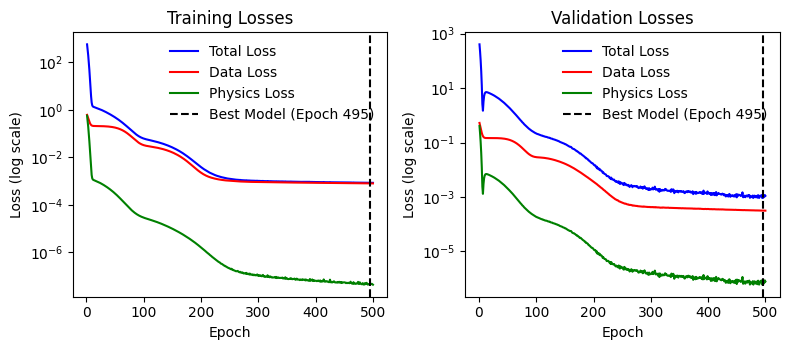

In [7]:
# we want to evaluate the model performance on the training dataset
model.plot_losses("plots")


Next, we evaluate model performacne 

In [8]:



result_df = model.evaluate(scaler, df, all_loader, cfg['data']['feature_names'], cfg['data']['target_names'] )


Best model loaded successfully.


Evaluating PINN: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:01<00:00, 84.26it/s]


Saved evaluation DataFrame to: plots\pinn_evaluation.csv


In [9]:
print( df.columns )

print( result_df.head )

Index(['t', 'j', 'U', 'T', 'delta_j', 'cumulative_current',
       'temperature_slope', 'rolling_mean_current', 'rolling_std_current',
       'U_perf', 'eta_kinetic_perf', 'R_ohmic_perf', 'U_deg'],
      dtype='object')
<bound method NDFrame.head of                   t         j          T  u_deg_targ  u_deg_pred     f_pde  \
0          0.000000  0.199950  31.900000   -0.234970    0.088629 -0.004426   
1          0.008333  0.200000  32.700001    0.107468    0.087819 -0.004292   
2          0.016667  0.200000  33.500000    0.116968    0.087027 -0.004162   
3          0.025000  0.200000  33.600002    0.116968    0.086929 -0.004146   
4          0.033333  0.200000  34.399998    0.125968    0.086143 -0.004017   
...             ...       ...        ...         ...         ...       ...   
131150  1096.891602  0.200000  92.499992    0.042868    0.035780  0.000566   
131151  1096.900024  0.200000  92.499992    0.039768    0.035780  0.000566   
131152  1096.908325  0.200000  92.300003    0.04

In [10]:
plot_pinn_performance(result_df, cfg['data']['feature_names'], cfg['data']['target_names'], train_frac = cfg["data"]["train_frac"], val_frac = cfg["data"]["val_frac"], save_path = "plots")

u_deg_targ
✅ PINN performance plot saved to plots (including residuals)


In [11]:
# next, we use the trained model to evaluate a new dataset
# in this example, we import a DegradEL_forecast.csv dataset and preprocess it

In [12]:
# import the new dataset

#forecast_dp = Preprocessor("DegradEL_forecasting_ramping_data.csv")
#forecast_df = forecast_dp.preprocess(
#                    t0 = cfg["data"]["t0"],
#                    t1 = cfg["data"]["t1"],
#                    fitting_df = df,
#                    plot_fit = False,   
#                    plot_raw = False   
#                    )


At this point we have trained the PINN on a dataset. We then want to evaluate how this specific cell would perform if we gave it another test protocol. For this purpose, we now test the case where the cell is operating based on the solar PV profile. 

The "solarPV_data_for_evaluation_normalized.csv" file contains ~6 months of solar PV data normalized to current density values similar to what is contained in the original trainind dataset.

First, we initiate a new data Preprocessor for the new forecasting dataset.

In [22]:
fdp = Preprocessor("augmented_solarPV.csv")

In [23]:
fdp.load() # loading the data

,t,j,T,cumulative_current,temperature_slope,rolling_mean_current,rolling_std_current
0,0.000000,0.037902,90,0.000000,0.0,0.037902,0.000000
1,0.016667,0.038885,90,0.000648,0.0,0.038393,0.000695
2,0.033333,0.039867,90,0.001313,0.0,0.038885,0.000983
3,0.050000,0.040848,90,0.001993,0.0,0.039376,0.001268
4,0.066667,0.041829,90,0.002690,0.0,0.039866,0.001552
...,...,...,...,...,...,...,...
298852,4999.916667,0.070613,90,556.974533,0.0,0.063173,0.017025
298853,4999.933333,0.069264,90,556.975688,0.0,0.063475,0.016807
298854,4999.950000,0.067915,90,556.976819,0.0,0.063761,0.016584
298855,4999.966667,0.066564,90,556.977929,0.0,0.064033,0.016357


Using the previous training datasset ("df"), we can still fit performance data on the new test protocol even though it does not contain any cell voltages. This is done by specifying fitting_df = df.

In [24]:
forecast_df = fdp.fit_performance( t0 = cfg["data"]["t0"],
                    t1 = cfg["data"]["t1"],
                    fitting_df = df )


In [25]:
print(forecast_df.columns)

Index(['t', 'j', 'T', 'cumulative_current', 'temperature_slope',
       'rolling_mean_current', 'rolling_std_current', 'U_perf',
       'eta_kinetic_perf', 'R_ohmic_perf'],
      dtype='object')


We inspect that the new forecast_df does indeed contain the performance cell voltage for all time values.

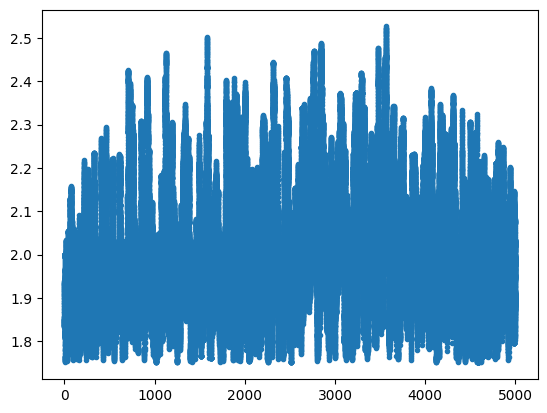

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(forecast_df['t'], forecast_df['U_perf'], '.')

In [27]:
# we want to use the same scaler from before, so the data is scaled in an identical way

forecast_loader = scaler.get_inference_loader(
    forecast_df,
    batch_size=cfg["training"]["batch_sizes"][0] )

# we set the feature and target names to the same as in the previous example
# however, the dataframe (df) is the new dataset
# result_df = model.evaluate(scaler, df, all_loader, cfg['data']['feature_names'], cfg['data']['target_names'])

# 

In [28]:
forecast_result_df = model.evaluate(scaler, forecast_df, forecast_loader, cfg['data']['feature_names'], cfg['data']['target_names'], save_folder = "forecast_plots")

Best model loaded successfully.


Evaluating PINN: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:02<00:00, 105.39it/s]


Saved evaluation DataFrame to: forecast_plots\pinn_evaluation.csv


In [29]:

plot_pinn_performance(forecast_result_df, cfg['data']['feature_names'], cfg['data']['target_names'], train_frac = 0.0, val_frac = 0.0, save_path = "forecast_plots")

u_deg_targ
✅ PINN performance plot saved to forecast_plots


In [30]:
print(forecast_result_df)

                  t         j     T  u_deg_targ  u_deg_pred     f_pde  \
0          0.000000  0.037902  90.0         NaN    0.062474  0.000153   
1          0.016667  0.038885  90.0         NaN    0.062451  0.000144   
2          0.033333  0.039867  90.0         NaN    0.062426  0.000138   
3          0.050000  0.040848  90.0         NaN    0.062400  0.000133   
4          0.066667  0.041829  90.0         NaN    0.062374  0.000127   
...             ...       ...   ...         ...         ...       ...   
298852  4999.916504  0.070613  90.0         NaN    0.123536  0.124821   
298853  4999.933105  0.069264  90.0         NaN    0.123408  0.124432   
298854  4999.950195  0.067915  90.0         NaN    0.123278  0.124041   
298855  4999.966797  0.066564  90.0         NaN    0.123145  0.123651   
298856  4999.983398  0.065211  90.0         NaN    0.123009  0.123261   

        eta_kinetic_deg  R_ohmic_deg    G_pred   u_deg_t  cumulative_current  \
0              0.067102    -0.574625 -0.452